<a href="https://colab.research.google.com/github/Yang-yamper/research-for-graduation/blob/main/%E3%81%8B%E3%82%8B%E3%81%9F%E5%88%A4%E5%88%A5%E6%A9%9F%EF%BC%88verVGG)%E3%80%80Resnet%E5%8F%82%E8%80%83_%E3%80%8014%E5%B1%A4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


各種ライブラリのインポート

In [2]:
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os 
import keras
from tqdm import tqdm, tqdm_notebook
from keras.layers import Input, Conv2D, GlobalAveragePooling2D, BatchNormalization, MaxPooling2D
from keras.layers import Add, Activation, Flatten, Dense, Dropout
from keras.models import Model
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator

In [3]:
from PIL import Image
import os, glob
import numpy as np
import random, math

#画像が保存されているルートディレクトリのパス
root_dir = "/content/drive/MyDrive/result_range"
# 商品名
categories = ["left","right"]

# 画像データ用配列
X = []
# ラベルデータ用配列
Y = []

#画像データごとにadd_sample()を呼び出し、X,Yの配列を返す関数
def make_sample(files):
    global X, Y
    X = []
    Y = []
    for cat, fname in files:
        add_sample(cat, fname)
    return np.array(X), np.array(Y)

#渡された画像データを読み込んでXに格納し、また、
#画像データに対応するcategoriesのidxをY格納する関数
def add_sample(cat, fname):
    img = Image.open(fname)
    img = img.convert("RGB")
    img = img.resize((224,224))
    data = np.asarray(img)
    X.append(data)
    Y.append(cat)

#全データ格納用配列
allfiles = []

#カテゴリ配列の各値と、それに対応するidxを認識し、全データをallfilesにまとめる
for idx, cat in enumerate(categories):
    image_dir = root_dir + "/" + cat
    files = glob.glob(image_dir + "/*.jpg")
    for f in files:
        allfiles.append((idx, f))

#シャッフル後、学習データと検証データに分ける
random.shuffle(allfiles)
th = math.floor(len(allfiles) * 0.8)
train = allfiles[0:th]
test  = allfiles[th:]
X_train, y_train = make_sample(train)
X_test, y_test = make_sample(test)
xy = (X_train, X_test, y_train, y_test)
#データを保存する（データの名前を「tea_data.npy」としている）
np.save("/content/drive/MyDrive/test_caruta.npy", xy)

/usr/local/lib/python3.7/dist-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


モデルの構築

In [9]:
input_ = Input(shape=(224, 224,3))#横の数、縦の数、RGB
c = Conv2D(32, (3,3), padding='same')(input_)
c = Conv2D(32, (3,3), padding='same')(c)
c = BatchNormalization()(c)
c = Activation('relu')(c)
c = MaxPooling2D(pool_size=(2,2))(c)
c = Conv2D(64, (3,3), padding='same')(c)
c = Conv2D(64, (3,3), padding='same')(c)
c = Conv2D(64, (3,3), padding='same')(c)
c = BatchNormalization()(c)
c = Activation('relu')(c)
c = MaxPooling2D(pool_size=(2,2))(c)
c = Conv2D(64, (3,3), padding='same')(c)
c = Conv2D(64, (3,3), padding='same')(c)
c = Conv2D(64, (3,3), padding='same')(c)
c = BatchNormalization()(c)
c = Activation('relu')(c)
c = MaxPooling2D(pool_size=(2,2))(c)
c = Conv2D(64, (3,3), padding='same')(c)
c = Conv2D(64, (3,3), padding='same')(c)
c = Conv2D(64, (3,3), padding='same')(c)
c = BatchNormalization()(c)
c = Activation('relu')(c)
c = MaxPooling2D(pool_size=(2,2))(c)
c = Flatten()(c)
c = Dense(128, activation='relu')(c)
c = Dropout(0.25)(c)
c = Dense(256, activation='relu')(c)
c = Dropout(0.25)(c)
c = Dense(2, activation='sigmoid')(c)

model = Model(input_, c)

model.summary()
model.compile(loss='binary_crossentropy', optimizer=RMSprop(learning_rate=1e-4),metrics=["acc"])

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_55 (Conv2D)          (None, 224, 224, 32)      896       
                                                                 
 conv2d_56 (Conv2D)          (None, 224, 224, 32)      9248      
                                                                 
 batch_normalization_20 (Bat  (None, 224, 224, 32)     128       
 chNormalization)                                                
                                                                 
 activation_20 (Activation)  (None, 224, 224, 32)      0         
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 112, 112, 32)     0         
 g2D)                                                      

モデルの正規化

In [10]:
from keras.utils import np_utils
import numpy as np

categories = ["left","right"]
nb_classes = len(categories)

X_train, X_test,y_train, y_test = np.load("/content/drive/MyDrive/test_caruta.npy", allow_pickle=True)

#データの正規化
X_train = X_train.astype("float") / 255
X_test  = X_test.astype("float")  / 255

#kerasで扱えるようにcategoriesをベクトルに変換
y_train = np_utils.to_categorical(y_train, nb_classes)
y_test  = np_utils.to_categorical(y_test, nb_classes)

モデルの学習

In [11]:
model = model.fit(X_train,
                  y_train,
                  epochs=30,
                  batch_size=20,
                  validation_data=(X_test,y_test))

Epoch 1/30
59/59 [==============================] - 508s 9s/step - loss: 0.4406 - acc: 0.8065 - val_loss: 0.7056 - val_acc: 0.5240
Epoch 2/30
59/59 [==============================] - 503s 9s/step - loss: 0.1745 - acc: 0.9366 - val_loss: 1.1155 - val_acc: 0.5240
Epoch 3/30
59/59 [==============================] - 502s 9s/step - loss: 0.0927 - acc: 0.9700 - val_loss: 1.9447 - val_acc: 0.5240
Epoch 4/30
59/59 [==============================] - 501s 8s/step - loss: 0.0651 - acc: 0.9863 - val_loss: 2.4367 - val_acc: 0.5240
Epoch 5/30
59/59 [==============================] - 512s 9s/step - loss: 0.0355 - acc: 0.9906 - val_loss: 2.7144 - val_acc: 0.5240
Epoch 6/30
59/59 [==============================] - 501s 9s/step - loss: 0.0260 - acc: 0.9932 - val_loss: 2.8998 - val_acc: 0.5240
Epoch 7/30
59/59 [==============================] - 501s 8s/step - loss: 0.0378 - acc: 0.9906 - val_loss: 1.6128 - val_acc: 0.5582
Epoch 8/30
59/59 [==============================] - 501s 8s/step - loss: 0.0198 - a

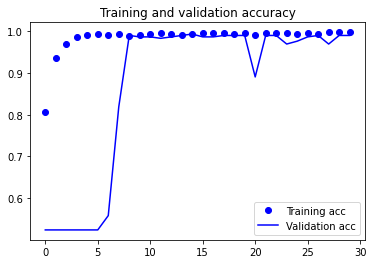

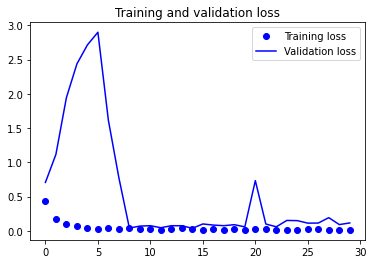

In [12]:
import matplotlib.pyplot as plt

acc = model.history['acc']
val_acc = model.history['val_acc']
loss = model.history['loss']
val_loss = model.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.savefig('property')

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.savefig('loss')

In [ ]:
#モデルの保存

json_string = model.model.to_json()
open('/content/drive/MyDrive/caruta_predict.json', 'w').write(json_string)

#重みの保存

hdf5_file = "/content/drive/MyDrive/caruta_predict.hdf5"
model.model.save(hdf5_file)

In [ ]:
from PIL import Image
import os, glob
import numpy as np
import random, math

# 画像が保存されているディレクトリのパス
root_dir = "/content/drive/MyDrive/result_range"
# 画像が保存されているフォルダ名
categories =["left","right"]

X = [] # 画像データ
Y = [] # ラベルデータ

# フォルダごとに分けられたファイルを収集
#（categoriesのidxと、画像のファイルパスが紐づいたリストを生成）
allfiles = []
for idx, cat in enumerate(categories):
    image_dir = root_dir + "/" + cat
    files = glob.glob(image_dir + "/*.jpg")
    for f in files:
        allfiles.append((idx, f))

for cat, fname in allfiles:
    img = Image.open(fname)
    img = img.convert("RGB")
    img = img.resize((224,224))
    data = np.asarray(img)
    X.append(data)
    Y.append(cat)

x = np.array(X)
y = np.array(Y)

np.save("/content/drive/MyDrive/tea_data_test_X_150.npy", x)
np.save("/content/drive/MyDrive/tea_data_test_Y_150.npy", y)

In [ ]:
# モデルの精度を測る

#評価用のデータの読み込み
test_X = np.load("/content/drive/MyDrive/tea_data_test_X_150.npy")
test_Y = np.load("/content/drive/MyDrive/tea_data_test_Y_150.npy")

#Yのデータをone-hotに変換
from keras.utils import np_utils

test_Y = np_utils.to_categorical(test_Y, 2)

score = model.model.evaluate(x=test_X,y=test_Y)

print('loss=', score[0])
print('accuracy=', score[1])

46/46 [==============================] - 89s 2s/step - loss: 348.4492 - acc: 0.6973
loss= 348.44921875
accuracy= 0.6972602605819702
